# Part 2 - Classification using fast.ai
In my last year's [eargasm music project](https://github.com/adamsiemaszkiewicz/eargasm-music), I classified my music library using pre-developed audio features extracted using Spotify API. This project is an attempt to test new ways of classifying sounds based on their raw sound representation and, later on, try to ensamble various different methods for a better performing classifier.

This notebook will use the audio clips converted into spectogram images in the previous step to build a classification model using fast.ai.

# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/sound_classifier /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/sound_classifier': File exists
/content/gdrive/My Drive/Colab Notebooks/sound_classifier


## Import libraries
- `numpy` - linear algebra
- `pandas` -  data manipulation & analysis
- `shutil` - high-level file operations
- `tqdm` - progress bars
- `gc` - garbage collector (memory cleanup)

In [3]:
import numpy as np
import pandas as pd
import shutil
import tqdm.notebook as tq
import gc

## fast.ai
Install & import the latest version of fast.ai high-level deep learning library and load its computer vision modules.

https://docs.fast.ai/

In [4]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.3.1)


In [5]:
import fastai
print(f'fast.ai version: {fastai.__version__}')
from fastai import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.callback.tracker import EarlyStoppingCallback, SaveModelCallback, ReduceLROnPlateau

fast.ai version: 2.3.1


# Proprocessing
In order to feed our data to the model we need to prepare our dataset first. The steps we're going to take are:
1. Load CSV file with dataset meta data
2. Set the path where the files are stored
3. Clean up duplicate files
4. Arrange dataset into predefined folds.

## Load meta data
Import CSV file containing meta information about the files in the dataset into a DataFrame.

In [6]:
# path to csv file containing meta data for the dataset
META_CSV = './ESC-50/meta/esc50.csv'

# load csv & preview the DataFrame
df = pd.read_csv(META_CSV)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


## Set dataset path
Set the main dataset path and list the files.

In [7]:
path = Path('./spectograms/')
path.ls()

(#2007) [Path('spectograms/3-152007-A-20.png'),Path('spectograms/3-152007-B-20.png'),Path('spectograms/3-152007-C-20.png'),Path('spectograms/3-152007-D-20.png'),Path('spectograms/3-152007-E-20.png'),Path('spectograms/3-152020-A-36.png'),Path('spectograms/3-152020-B-36.png'),Path('spectograms/3-152020-C-36.png'),Path('spectograms/3-152039-A-3.png'),Path('spectograms/3-152039-B-3.png')...]

## Duplicate files
Due to some Google Drive related bugs there might be some duplicate files. Let's clean them up.

In [8]:
# iterate through the files in the dataset path
for fname in os.listdir(path):

  # drop the file extension
  name = fname.split('.')[0]
  # check if the filename ends with (1) and remove the file
  if name.endswith('(1)'):
    print(os.path.join(path, fname))
    os.remove(os.path.join(path, fname))

## Cross-validation folds
The dataset is divided into 5 folds which we need to keep in order to avoid data leakage, as some of the audio files come from the same recording. Let's keep each fold seperately in their corresponding folder.

### List files
Let's create a DataFrame listing files belonging to each fold.

In [9]:
# specify number of folds available
FOLDS_NUMBER = 5

# make a dict comprehension with list of filenames for each fold
folds_dict = {
          f'fold{n+1}':[f for f in df.loc[df['fold'] == n+1].filename] \
          for n in range(FOLDS_NUMBER)
         }

# create and preview a DataFrame based on the dictionary
df_folds = pd.DataFrame(folds_dict)
df_folds.head()

,fold1,fold2,fold3,fold4,fold5
0,1-100032-A-0.wav,2-100648-A-43.wav,3-100018-A-18.wav,4-102844-A-49.wav,5-103415-A-2.wav
1,1-100038-A-14.wav,2-100786-A-1.wav,3-100024-A-27.wav,4-102844-B-49.wav,5-103416-A-2.wav
2,1-100210-A-36.wav,2-101676-A-10.wav,3-100024-B-27.wav,4-102844-C-49.wav,5-103418-A-2.wav
3,1-100210-B-36.wav,2-102414-A-17.wav,3-101381-A-33.wav,4-102871-A-42.wav,5-103420-A-2.wav
4,1-101296-A-19.wav,2-102414-B-17.wav,3-101381-B-33.wav,4-107117-A-33.wav,5-103421-A-2.wav


### Create directories
Create folders for each fold to store the spectogram files.

In [10]:
# iterate through folds
for fold in df_folds.columns:

  # set the directory path
  dir = path/fold
  
  # create folder if it doesn't exist yet
  if not os.path.isdir(dir):
    os.mkdir(dir)
    print(f'Directory {dir} created.')
  else:
    print(f'Directory {dir} already exists.')

Directory spectograms/fold1 already exists.
Directory spectograms/fold2 already exists.
Directory spectograms/fold3 already exists.
Directory spectograms/fold4 already exists.
Directory spectograms/fold5 already exists.


### Copy files
Copy spectogram files to the corresponding folders, so it's possible for fast.ai to process them.

In [11]:
# iterate through folds
for fold in df_folds.columns:

  # iterate through files within a fold
  for file in df_folds[fold]:

    # change file extension from wav to png
    file = re.sub('wav', 'png', file)

    # check if file already exists and copy from source to destination if it doesn't
    if not os.path.exists(path/fold/file):
      shutil.copy(path/file, path/fold)
      print(f'Copied {file} to {fold}')
    else:
      print(f'File {file} already exists.')

File 1-100032-A-0.png already exists.
File 1-100038-A-14.png already exists.
File 1-100210-A-36.png already exists.
File 1-100210-B-36.png already exists.
File 1-101296-A-19.png already exists.
File 1-101296-B-19.png already exists.
File 1-101336-A-30.png already exists.
File 1-101404-A-34.png already exists.
File 1-103298-A-9.png already exists.
File 1-103995-A-30.png already exists.
File 1-103999-A-30.png already exists.
File 1-104089-A-22.png already exists.
File 1-104089-B-22.png already exists.
File 1-105224-A-22.png already exists.
File 1-110389-A-0.png already exists.
File 1-110537-A-22.png already exists.
File 1-115521-A-19.png already exists.
File 1-115545-A-48.png already exists.
File 1-115545-B-48.png already exists.
File 1-115545-C-48.png already exists.
File 1-115546-A-48.png already exists.
File 1-115920-A-22.png already exists.
File 1-115920-B-22.png already exists.
File 1-115921-A-22.png already exists.
File 1-116765-A-41.png already exists.
File 1-11687-A-47.png alread

# Model training
Let's go through the process for one fold first.

## Reproducability
Set the global seed to ensure reproducability throughout the code.

In [12]:
set_seed(0)

## Single fold DataFrame
Define a function to crate a DataFrame to use in each fold's training. We'll exclude fold number 5, which will be used later as a test set.

In [13]:
def fold_df(fold_number):
  '''Create a DataFrame with data for a single fold training.'''

  # create a training set
  df_train = df.loc[df['fold']!=5, :].copy()

  # replace original wav audio file extension with spectogram png extension
  df_train['filename'] = df_train['filename'] \
                        .apply(lambda x: x.split('.')[0])+'.png'

  # tag validation samples based on specified fold number
  df_train['is_valid'] = df_train['fold'] \
                        .apply(lambda x: True if x==fold_number else False)

  # get rid of columns we no longer need
  df_train = df_train.drop(
      columns=['fold', 'target', 'esc10', 'src_file', 'take']
      )
  
  # reset index
  df_train = df_train.reset_index(drop=True)
  
  return df_train

In [14]:
# display sample fold DataFrame
fold_df(4)

,filename,category,is_valid
0,1-100032-A-0.png,dog,False
1,1-100038-A-14.png,chirping_birds,False
2,1-100210-A-36.png,vacuum_cleaner,False
3,1-100210-B-36.png,vacuum_cleaner,False
4,1-101296-A-19.png,thunderstorm,False
...,...,...,...
1595,4-99193-B-4.png,frog,True
1596,4-99644-A-4.png,frog,True
1597,4-99644-B-4.png,frog,True
1598,4-99644-C-4.png,frog,True


## Data Loaders
Let's build a DataLoaders object for a single fold using `from_df()` method and the DataFrame we've just created. To do it we need to define:
- `df` - DataFrame containing the dataset info
- `path` - path where the dataset files are stored
- `fn_col` - column name containing filenames
- `label_col` - column name containing labels
- `valid_col` - column name specifying validation samples
- `item_tfms` - transforms made to the items before batching 

  The only data transformation we're going to use it resizing and squishing our spectograms into squares. https://docs.fast.ai/vision.augment.html
- `bs` - batch size

`ImageDataLoaders` - https://docs.fast.ai/vision.data.html#ImageDataLoaders



In [15]:
# define type of transformations made to the items
item_tfms = Resize(512, method=ResizeMethod.Squish)

# create DataLoaders object
dls = ImageDataLoaders.from_df(
    df=fold_df(1),
    path=path,
    fn_col='filename',
    label_col='category',
    valid_col='is_valid',
    item_tfms=item_tfms,
    bs=64
    )

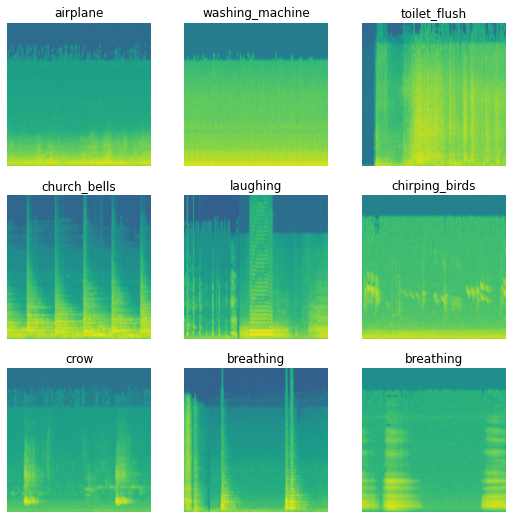

In [16]:
# preview one training batch
dls.train.show_batch()

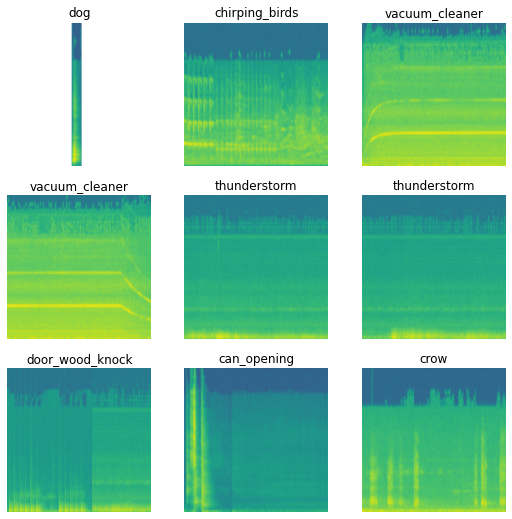

In [17]:
# preview one validation batch
dls.valid.show_batch()

## Training
We're now ready to build and train a classification model. To do so we need to:
1. Create a learner
2. Find an optimal learning rate
3. Train the model
4. Evaluate training progress using learning curves.

Let's start with a basic model and see how we can improve it later on.

### Learner
Create a convolutional netural network learner with:
- our previously made DataLoaders
- simple 18-layer ResNet architecture
- error rate & accuracy evalutation metrics
- use transfer learning by downloading ResNet18 weights

https://docs.fast.ai/learner.html

In [18]:
learn = cnn_learner(
    dls=dls,
    arch=resnet18,
    metrics=[accuracy],
    pretrained=True # download pretrained weights 
    )

### Learning rate
Before training let's find an optimal learning rate for our model to learn quicker. To do so we need to select the learning rate value in the point where the steepness of the loss decline is the biggest or in 1/10 of the value of the lowest point.

https://docs.fast.ai/callback.schedule.html#Learner.lr_find

Lowest point /10: 1.20e-02, steepest point: 6.31e-03


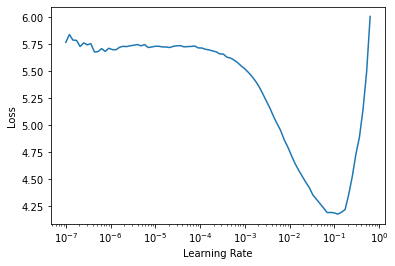

In [19]:
lr_min, lr_steep = learn.lr_find()
print(f'Lowest point /10: {lr_min:.2e}, steepest point: {lr_steep:.2e}')

### Basic training
Once we have a good learning rate to train our model, let's fine-tune the pretrained model. What the `fine_tune()` method does here is it:
- Trains the randomly added layers for one epoch, with all other layers frozen (epoch 0)
- Unfreezes all of the layers, and trains them all for the number of epochs requested
- Uses the optimal learning rate found in the previous step

https://docs.fast.ai/callback.schedule.html#Learner.fine_tune

Additionally we'll use some callbacks to keep track of and react to the learning process:
https://docs.fast.ai/callback.tracker
- `EarlyStoppingCallback` that terminates training when monitored quantity stops improving
- `SaveModelCallback` that saves the model's best during training and loads it at the end
- `ReduceLROnPlateau` that reduces learning rate when a metric has stopped improving

After the training we're going to end up with the model with the lowest validation test loss.


In [20]:
cbs = [
       EarlyStoppingCallback(monitor='valid_loss', patience=5),
       SaveModelCallback(monitor='valid_loss', fname='basic-model'),
      #  ReduceLROnPlateau(monitor='valid_loss', patience=3) 
       ]

learn.fine_tune(
    epochs=50,
    base_lr=lr_steep,
    cbs=cbs
    )

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,4.442070,3.731484,0.850000,0.150000,00:35


Better model found at epoch 0 with valid_loss value: 3.7314836978912354.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.747556,2.609777,0.665000,0.335000,00:47
1,1.241861,2.025492,0.565000,0.435000,00:43
2,0.896187,1.838838,0.500000,0.500000,00:43
3,0.644801,1.758304,0.470000,0.530000,00:42
4,0.460132,1.684654,0.450000,0.550000,00:42
5,0.335488,1.641033,0.442500,0.557500,00:43
6,0.249609,1.653419,0.440000,0.560000,00:43
7,0.187785,1.709212,0.467500,0.532500,00:42
8,0.146314,1.751100,0.445000,0.555000,00:42
9,0.120988,1.847479,0.447500,0.552500,00:42


Better model found at epoch 0 with valid_loss value: 2.6097774505615234.
Better model found at epoch 1 with valid_loss value: 2.025491714477539.
Better model found at epoch 2 with valid_loss value: 1.8388378620147705.
Better model found at epoch 3 with valid_loss value: 1.7583038806915283.
Better model found at epoch 4 with valid_loss value: 1.6846542358398438.
Better model found at epoch 5 with valid_loss value: 1.6410331726074219.
No improvement since epoch 5: early stopping


### Learning curve
Plotting the losses of our model for both traininig and validation set we can see that our model reaches around 70% accuracy and the plateaus out.

https://docs.fast.ai/learner.html#Plotting-tools

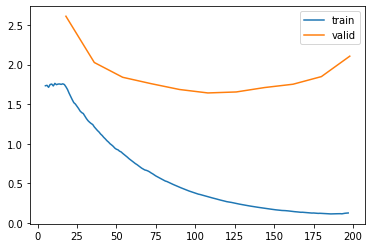

In [21]:
learn.recorder.plot_loss()

## Model interpretation
Let's interpret the results of our classification.

https://docs.fast.ai/interpret

### Results
Let's see some sample predictionsof our model. Each sample is marked either green (correct prediction) or red (false prediction) labeled with ground truth (top) and prediction (bottom).

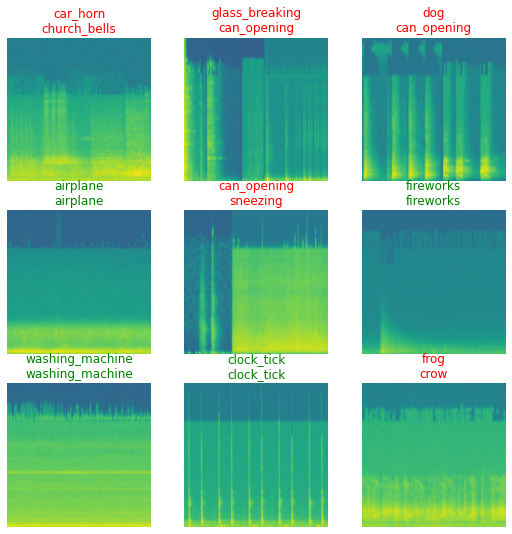

In [22]:
learn.show_results()

### Confusion matrix
Plot the confusion matrix to see the full representation of correct and false predictions ouf our basic model.

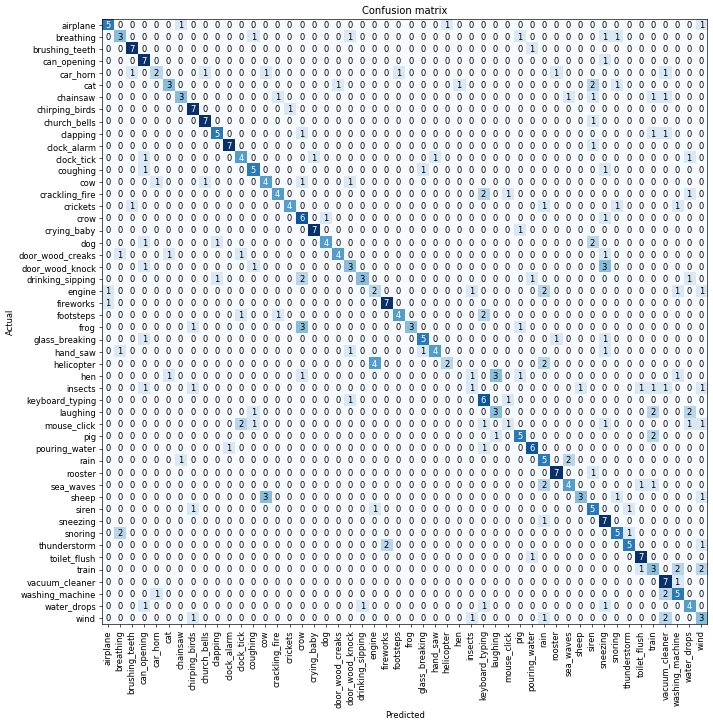

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Most confused
Let's see a list of largest confused predictions, presented as tuples of (actual class, predicted class, number of occurrences), with a minimal value of 3 confused predictions.

In [24]:
interp.most_confused(min_val=3)

[('helicopter', 'engine', 4),
 ('door_wood_knock', 'sneezing', 3),
 ('frog', 'crow', 3),
 ('hen', 'laughing', 3),
 ('sheep', 'cow', 3)]

### Classification report
Print scikit-learn classification report for our model. To get a better sense of mathematical performance of the model we can check the classification report containing values of metrics such as:
- $Precision = \frac{TP}{TP+FP}$ (What proportion of positive identifications was actually correct?)
- $Recall = \frac{TP}{TP+FN}$ (What proportion of actual positives was identified correctly?)
- $F1\ score = \frac{TP}{TP+1/2(FP+FN)}$ (The harmonic mean of precision and recall)
- $Accuracy = \frac{Number\ of\ correct\ predictions}{Total\ number\ of\ predictions}$ (What proportion of predictions was correct?)

where:

$TP - true\ positive$

$TN - true\ negative$

$FP - false\ positive$

$FN - false\ negative$

In [25]:
interp.print_classification_report()

                  precision    recall  f1-score   support

        airplane       0.71      0.62      0.67         8
       breathing       0.43      0.38      0.40         8
  brushing_teeth       0.78      0.88      0.82         8
     can_opening       0.50      0.88      0.64         8
        car_horn       0.50      0.25      0.33         8
             cat       0.60      0.38      0.46         8
        chainsaw       0.60      0.38      0.46         8
  chirping_birds       0.64      0.88      0.74         8
    church_bells       0.78      0.88      0.82         8
        clapping       0.71      0.62      0.67         8
     clock_alarm       0.88      0.88      0.88         8
      clock_tick       0.50      0.50      0.50         8
        coughing       0.56      0.62      0.59         8
             cow       0.50      0.50      0.50         8
  crackling_fire       0.67      0.50      0.57         8
        crickets       0.80      0.50      0.62         8
            c

# Test set validation
Once our training and validation is done let's see how our model performs on the data never seen before - test set.

## Test DataFrame
Create a DataFrame containing the file paths to the test spectograms and their labels. We're goinig to use fold number 5 for the test purposes, as the model hasn't seen this data before.

In [26]:
# create a test DataFrame
df_test  = df.loc[df['fold']==5, :].copy()

# change file extensions from wav to png to reflect our spectograms
df_test['filename'] = df_test['filename'].apply(lambda x: 'fold5/'+x.split('.')[0]+'.png')

# get rid of no longer needed columns and reset indexing
df_test = df_test.loc[:, ['filename', 'category']].reset_index(drop=True)

df_test.head()

,filename,category
0,fold5/5-103415-A-2.png,pig
1,fold5/5-103416-A-2.png,pig
2,fold5/5-103418-A-2.png,pig
3,fold5/5-103420-A-2.png,pig
4,fold5/5-103421-A-2.png,pig
...,...,...
395,fold5/5-263831-B-6.png,hen
396,fold5/5-263902-A-36.png,vacuum_cleaner
397,fold5/5-51149-A-25.png,footsteps
398,fold5/5-61635-A-8.png,sheep


## Test DataSet
Based on the DataFrame we've just generated, we can create a fast.ai `test_set` object which will contain tuples of our spectogram images and their labels.

https://docs.fast.ai/data.core.html#test_set

In [27]:
# make test set
tset = test_set(
    dsets=dls.valid_ds,
    test_items=df_test,
    with_labels=True
    )
tset

(#400) [(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(34)),(PILImage mode=RGB size=334x217, TensorCategory(40)),(PILImage mode=RGB size=334x217, TensorCategory(40)),(PILImage mode=RGB size=334x217, TensorCategory(40)),(PILImage mode=RGB size=334x217, TensorCategory(34))...]

'pig'

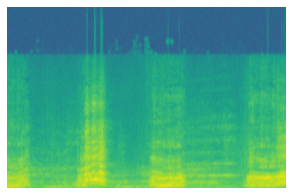

In [28]:
# test set sample
sample = tset[0]
# show a sample test spectogram
sample[0].show()
# create a transformer of category string to vocab id
cat = Categorize(vocab=tset.vocab)
# show a sample test label by decoding vocab id
cat.decode(sample[1])

## Test DataLoader
Create a test DataLoader from our test Dataset using validation transforms of our original DataLoaders (`dls`) along with the test labels and show one batch of the samples.

https://docs.fast.ai/data.core.html#DataLoaders.test_dl

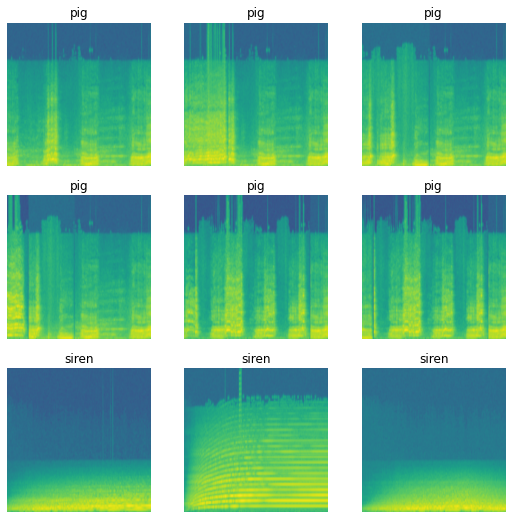

In [29]:
test_dl = dls.test_dl(
    dsets=dls.valid_ds,
    test_items=df_test,
    with_labels=True
    )
test_dl.show_batch()

## Classification results
Display a random batch of test set predictions

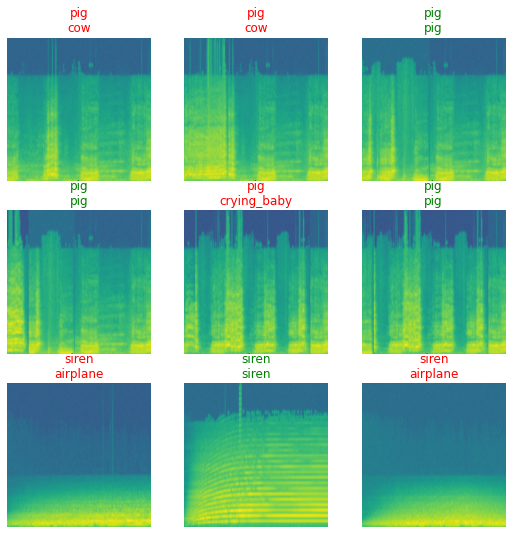

In [30]:
learn.show_results(dl=test_dl, shuffle=True)

## Sample prediction
Let's pick a random sample from our test set and see what the model we've just trained predicts. The `predict()` method will output:
- `pred` - the object predicted (with the class in this instance)
- `data` - the underlying data (here the corresponding index)
- `proba` - the raw probabilities

In [31]:
# img = data.train_ds[0][0]
gtruth = cat.decode(tset[0][1])
img = tset[0][0]
pred, data, proba = learn.predict(img)
# print(gtruth, pred)

## Results interpretation
Let's interpret the results of our test set evaluation using `ClassificationInterpretation`.

In [32]:
interp_test = ClassificationInterpretation.from_learner(learn, dl=test_dl)

### Confusion matrix

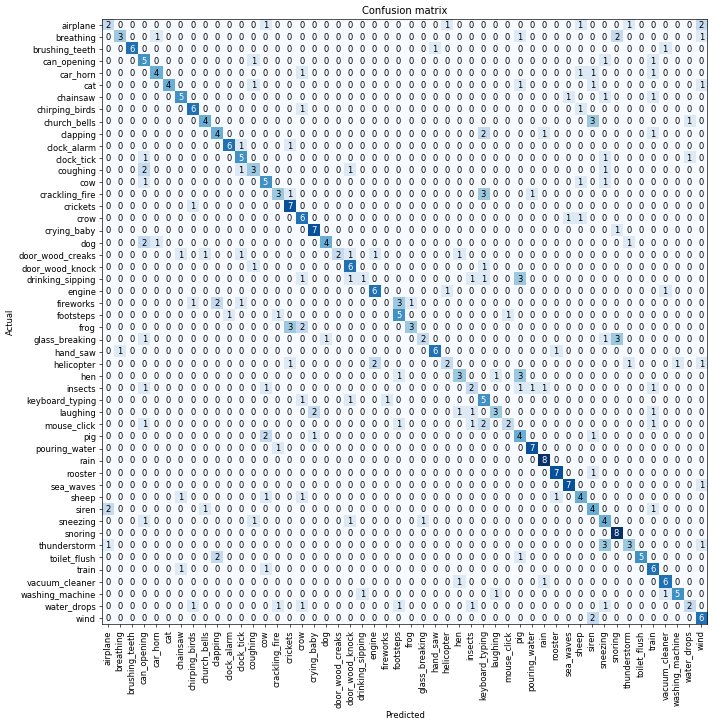

In [33]:
interp_test.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Most confused

In [34]:
interp_test.most_confused(min_val=3)

[('church_bells', 'siren', 3),
 ('crackling_fire', 'keyboard_typing', 3),
 ('drinking_sipping', 'pig', 3),
 ('fireworks', 'footsteps', 3),
 ('frog', 'crickets', 3),
 ('glass_breaking', 'snoring', 3),
 ('hen', 'pig', 3),
 ('thunderstorm', 'sneezing', 3)]

### Classification report

In [35]:
interp_test.print_classification_report()

                  precision    recall  f1-score   support

        airplane       0.40      0.25      0.31         8
       breathing       0.75      0.38      0.50         8
  brushing_teeth       1.00      0.75      0.86         8
     can_opening       0.33      0.62      0.43         8
        car_horn       0.67      0.50      0.57         8
             cat       1.00      0.50      0.67         8
        chainsaw       0.62      0.62      0.62         8
  chirping_birds       0.67      0.75      0.71         8
    church_bells       0.67      0.50      0.57         8
        clapping       0.50      0.50      0.50         8
     clock_alarm       0.86      0.75      0.80         8
      clock_tick       0.56      0.62      0.59         8
        coughing       0.43      0.38      0.40         8
             cow       0.45      0.62      0.53         8
  crackling_fire       0.50      0.38      0.43         8
        crickets       0.54      0.88      0.67         8
            c

## Sanity check

# Ensamble model
LEt's take a different approach and build a ensemble predictor using four different models trained using different folds. Let's repeat the steps we took with the basic model with some small changes for each fold and save the trained models into a dictionary:

1. Clear cache using Garbage Collector Python library to avoid running into CUDA memory problems.
2. Create a ImageDataLoaders object similarily to the basic model 
3. Initiate the learner with a deeper ResNet network with 50 hidden layers
4. Take advantage of the callbacks we used before for early training stopping.
5. Find an optimal learning late for each fold (this time taking the minimum/10 point for more robustness and automatization)

https://www.kaggle.com/phoenix9032/fastai-ensemble-tutorial-aerial-cactus

https://www.kaggle.com/thorgas1988/ensemble-of-3-fastai-models

https://walkwithfastai.com/Cross_Validation

In [ ]:
# initiate an empty dictionary to store the trained models
learners = dict()

# iterate through available folds
for n in tq.tqdm(range(1,5)):

  print(f'\nTraining fold {n}...')
  
  # collect memory garbage to avoid CUDA out of memory error
  gc.collect()

  # create DataLoaders object
  dls_tmp = ImageDataLoaders.from_df(
      df=fold_df(n),
      path=path,
      fn_col='filename',
      label_col='category',
      valid_col='is_valid',
      item_tfms=Resize(512, method=ResizeMethod.Squish),
      bs=64
      )
  
  # define a learner
  learn_tmp = cnn_learner(
    dls=dls_tmp,
    arch=resnet50,
    metrics=[accuracy],
    pretrained=True   
    )

  # define list of callbacks to use
  cbs = [
       EarlyStoppingCallback(monitor='valid_loss', patience=5),
       SaveModelCallback(monitor='valid_loss', fname=f'ensamble-model{n}')
       ]

  # find learning rate & supress plot display
  lr_min, lr_steep = learn_tmp.lr_find(show_plot=False)

  # train a model
  learn_tmp.fine_tune(
      epochs=50,
      base_lr=lr_min,
      cbs=cbs
      )

  # append learner to the container
  learners[f'fold{n}'] = learn_tmp  


Training fold 1...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.631166,3.006508,0.682500,0.317500,02:00


Better model found at epoch 0 with valid_loss value: 3.0065081119537354.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.795110,2.123765,0.512500,0.487500,02:36
1,0.925882,1.919534,0.430000,0.570000,02:33
2,0.540311,1.693094,0.440000,0.560000,02:33
3,0.378757,1.697321,0.440000,0.560000,02:33
4,0.390749,1.879270,0.457500,0.542500,02:33
5,0.386280,2.230406,0.482500,0.517500,02:33
6,0.518493,2.307286,0.487500,0.512500,02:33
7,0.614420,2.018936,0.470000,0.530000,02:33


Better model found at epoch 0 with valid_loss value: 2.123765468597412.
Better model found at epoch 1 with valid_loss value: 1.9195338487625122.
Better model found at epoch 2 with valid_loss value: 1.6930935382843018.
No improvement since epoch 2: early stopping

Training fold 2...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.546628,2.834009,0.627500,0.372500,02:00


Better model found at epoch 0 with valid_loss value: 2.8340086936950684.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.654393,1.863043,0.507500,0.492500,02:33
1,0.899607,1.778125,0.455000,0.545000,02:33
2,0.482678,1.826804,0.447500,0.552500,02:33
3,0.385257,2.011823,0.477500,0.522500,02:33
4,0.399821,2.076700,0.507500,0.492500,02:33
5,0.515678,1.968953,0.447500,0.552500,02:33
6,0.557305,2.217136,0.467500,0.532500,02:33


Better model found at epoch 0 with valid_loss value: 1.8630430698394775.
Better model found at epoch 1 with valid_loss value: 1.7781254053115845.
No improvement since epoch 1: early stopping

Training fold 3...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.776389,2.556679,0.677500,0.322500,02:00


Better model found at epoch 0 with valid_loss value: 2.5566794872283936.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.610367,1.844961,0.482500,0.517500,02:33
1,1.007318,1.622587,0.430000,0.570000,02:33
2,0.596490,1.669197,0.450000,0.550000,02:33
3,0.443680,1.635414,0.420000,0.580000,02:33
4,0.333743,1.682593,0.420000,0.580000,02:33
5,0.357063,1.725610,0.420000,0.580000,02:33
6,0.396628,1.701009,0.410000,0.590000,02:33


Better model found at epoch 0 with valid_loss value: 1.8449606895446777.
Better model found at epoch 1 with valid_loss value: 1.622586727142334.
No improvement since epoch 1: early stopping

Training fold 4...


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,3.724917,2.540906,0.595000,0.405000,02:00


Better model found at epoch 0 with valid_loss value: 2.5409061908721924.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.785478,1.892143,0.510000,0.490000,02:33
1,1.128129,1.716134,0.447500,0.552500,02:33
2,0.744131,1.574735,0.415000,0.585000,02:33


Better model found at epoch 0 with valid_loss value: 1.8921432495117188.
Better model found at epoch 1 with valid_loss value: 1.7161338329315186.
Better model found at epoch 2 with valid_loss value: 1.574735403060913.


In [ ]:
learners

## get_preds
https://docs.fast.ai/learner.html#Learner.get_preds

In [ ]:
inputs1, preds1, targs1, decoded1, losses1  = learners['fold1'].get_preds(
                                                dl=test_dl,
                                                with_input=True,
                                                with_decoded=True,
                                                with_loss=True
                                                )
inputs2, preds2, targs2, decoded2, losses2  = learners['fold2'].get_preds(
                                                dl=test_dl,
                                                with_input=True,
                                                with_decoded=True,
                                                with_loss=True
                                                )
inputs3, preds3, targs3, decoded3, losses3  = learners['fold3'].get_preds(
                                                dl=test_dl,
                                                with_input=True,
                                                with_decoded=True,
                                                with_loss=True
                                                )
inputs4, preds4, targs4, decoded4, losses4  = learners['fold4'].get_preds(
                                                dl=test_dl,
                                                with_input=True,
                                                with_decoded=True,
                                                with_loss=True
                                                )


# Learner.get_preds(ds_idx=1, dl=None, with_input=False, with_decoded=False, with_loss=False, act=None, inner=False, reorder=True, cbs=None, save_preds=None, save_targs=None, concat_dim=0)

In [ ]:
for p in [preds1, preds2, preds3, preds4]:
  print(accuracy(p, targs1))

In [ ]:
# hat = tst_preds[0]
# for pred in tst_preds[1:]:
#   hat += pred

hat = ((preds1+preds2+preds3+preds4)/4)
hat

In [ ]:
interp_test = ClassificationInterpretation(
    test_dl,
    inputs1,
    (preds1+preds2+preds3+preds4)/4,
    targs1,
    decoded,
    losses)

In [ ]:
accuracy(hat, targs1)

In [ ]:
asdfasdf

In [ ]:
tset.vocab

In [ ]:
# show a sample test label
cat = Categorize(vocab=tset.vocab)
cat.decode(decoded1[0])

In [ ]:
((preds1+preds2+preds3+preds4)/4)[0]

In [ ]:
cat

In [ ]:
targs4

In [ ]:
losses

In [ ]:
interp_test.plot_confusion_matrix(figsize=(12,12), dpi=60)

- https://towardsdatascience.com/fantastic-and-straightforward-image-classification-with-fastai-library-for-pytorch-30c3380ac284
- https://towardsdatascience.com/longform-audio-classification-in-fastaudio-76d81825d29b
- https://towardsdatascience.com/how-to-resume-an-interrupted-training-session-in-fastai-77c4f36cd3a1
- https://analyticsindiamag.com/a-hands-on-guide-to-regression-with-fast-ai/
- https://gist.github.com/hududed/dc2bc9eaf8cc9254a8fb4f6cc8faa00b
- https://muellerzr.github.io/fastinference/shap.interp/
- https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb
- https://www.kaggle.com/mentalwanderer/image-classification-workflow-with-fast-ai
- https://muellerzr.github.io/fastblog/2020/08/10/testdl.html
- https://muellerzr.github.io/fastblog/2020/08/21/beginner.html
- https://medium.com/analytics-vidhya/image-classification-using-fastai-5ff5b374d414
- https://github.com/fastai/fastbook/blob/master/05_pet_breeds.ipynb
- https://www.kaggle.com/mentalwanderer/image-classification-workflow-with-fast-ai
- https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89
- https://www.kaggle.com/drcapa/esc-50-eda-pytorch
- https://www.kaggle.com/sreyareddy15/85-validation-accuracy-tensorflow
- https://www.kaggle.com/aipythoner/fastai-resnet50-pretrained-on-spectrogram
- https://www.kaggle.com/goldeneye007/5-fold-cv-res50-fastai-81-15-accuracy
- https://medium.com/jovianml/classifying-environmental-audio-recordings-9500a2112234
- https://towardsdatascience.com/deep-learning-for-diagnosis-of-skin-images-with-fastai-792160ab5495
- https://wandb.ai/jhartquist/fastaudio-esc-50/reports/Fine-tuning-ResNet-18-for-Audio-Classification--VmlldzoyNjU3OTQ
- https://enzokro.dev/spectrogram_normalizations/2020/09/10/Normalizing-spectrograms-for-deep-learning.html

In [ ]:
def classify(cases, classifier='knn', PCA=False, debug=False):
    results = []
    class_count = len(cases['category'].unique())
    confusion = np.zeros((class_count, class_count), dtype=int)
    
    for fold in range(1, 6):
        train = cases[cases['fold'] != fold].copy()
        test = cases[cases['fold'] == fold].copy()
        classifier_name = ''

        if PCA:
            pca = sk.decomposition.PCA()
            pca.fit(train.loc[:, features_start:features_end])
            train.loc[:, features_start:features_end] = pca.transform(train.loc[:, features_start:features_end])
            test.loc[:, features_start:features_end] = pca.transform(test.loc[:, features_start:features_end])

        if classifier == 'knn':
            classifier_name = 'k-NN'
            knn = sk.neighbors.KNeighborsClassifier(n_neighbors=8)
            knn.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = knn.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'rf':
            classifier_name = 'Random Forest'
            rf = sk.ensemble.RandomForestClassifier(n_estimators=500, random_state=20150420)
            rf.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = rf.predict(test.loc[:, features_start:features_end])
            
        if classifier == 'svm':
            classifier_name = 'Support Vector Machine (SVM)'
            svm = sk.svm.SVC(C=0.1, kernel='linear', random_state=20150420)
            svm.fit(train.loc[:, features_start:features_end], train['category'])
            test.loc[:, 'prediction'] = svm.predict(test.loc[:, features_start:features_end])

        accuracy = np.sum(test['category'] == test['prediction']) / float(len(test['category']))
        results.append(accuracy)
        confusion_current = sk.metrics.confusion_matrix(test['category'], test['prediction'])
        confusion = confusion + confusion_current
        
        print 'Classifying fold {0} with {1} classifier. Accuracy: {2}%'.format(fold, classifier_name, to_percentage(accuracy))
        if debug:
            print 'Confusion matrix:\n', confusion_current, '\n'
        
    print 'Average accuracy: {0}%\n'.format(to_percentage(np.mean(results)))
    return confusion, results

In [ ]:
result_csv = 'submission.csv'
test_path = '../input/test/test/'

def ensemble_predition(test_img):
    img = open_image(test_path + test_img)
    
    resnet50_predicition = resnet50_learner.predict(img)
    densenet121_predicition = densenet121_learner.predict(img)
    vgg_predicition = vgg_learner.predict(img)
    
    #ensemble average
    sum_pred = resnet50_predicition[2] + densenet121_predicition[2] + vgg_predicition[2]
    prediction = sum_pred / 3
    
    #prediction results
    predicted_label = torch.argmax(prediction).item()
    
    return predicted_label

#to give np array the correct style
submission_data = np.array([['dummy', 0]])

#progress bar
with tqdm(total=len(os.listdir(test_path))) as pbar:       
    #test all test images
    for img in os.listdir(test_path):
        label = ensemble_predition(img)
        new_np_array = np.array([[img, label]])
        submission_data = np.concatenate((submission_data, new_np_array), axis=0)
        pbar.update(1)

#remove dummy
submission_data = np.delete(submission_data, 0, 0)

#save final submission
result_df = pd.DataFrame(submission_data, columns=['id','has_cactus'])
result_df.to_csv(result_csv, index=False)